# Import Libraries

In [2]:
import pandas as pd  # Importing pandas for data manipulation
import numpy as np  # Importing numpy for numerical operations
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # Importing LabelEncoder and MinMaxScaler for preprocessing
from tensorflow.keras.models import Sequential  # Importing Sequential for creating a neural network model
from tensorflow.keras.layers import LSTM, Dense  # Importing LSTM and Dense layers for building the model
import matplotlib.pyplot as plt  # Importing matplotlib for plotting


# Load and Preprocess the Dataset

In [4]:
dataset = pd.read_csv('C:\\Users\\sravanthi\\OneDrive\\Desktop\\DS\\PRSA_data_2010.1.1-2014.12.31.csv')
dataset.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


# Handle Missing Values

In [6]:
dataset['pm2.5'].fillna(dataset['pm2.5'].median(), inplace=True)


C:\Users\sravanthi\AppData\Local\Temp\ipykernel_27820\3361980194.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['pm2.5'].fillna(dataset['pm2.5'].median(), inplace=True)


# Encode Categorical Variables

In [8]:
encoder = LabelEncoder()
dataset['cbwd'] = encoder.fit_transform(dataset['cbwd'])


# Drop Unnecessary Columns

In [10]:
dataset.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)


# Normalize the Data

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.values)


# Convert the Series to a Supervised Learning Problem

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Concatenate and drop rows with NaN
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# Frame as Supervised Learning Problem


In [16]:
reframed = series_to_supervised(scaled_data, 1, 1)


# Drop Unnecessary Columns

In [18]:
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14]], axis=1, inplace=True)


# Split the Data into Train and Test Sets

In [20]:
values = reframed.values
n_train_hours = 365 * 24  # Use one year of data for training
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [21]:
#Split into Inputs (X) and Outputs (y)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# Reshape Input Data for LSTM

In [23]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


# Design the LSTM Model

In [25]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')


C:\Users\sravanthi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the Model

In [27]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
122/122 - 6s - 50ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 2/50
122/122 - 1s - 10ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 3/50
122/122 - 1s - 10ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 4/50
122/122 - 1s - 11ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 5/50
122/122 - 1s - 11ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 6/50
122/122 - 1s - 11ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 7/50
122/122 - 1s - 12ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 8/50
122/122 - 2s - 20ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/50
122/122 - 1s - 11ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 10/50
122/122 - 1s - 9ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 11/50
122/122 - 1s - 9ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 12/50
122/122 - 1s - 10ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 13/50
122/122 - 1s - 9ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 14/50
122/122 - 1s - 9ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 15/50
122/122

# Plot the Training and Validation Loss

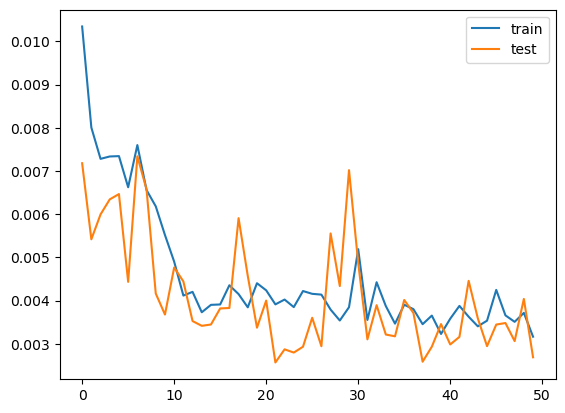

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# Make Predictions

In [31]:
yhat = model.predict(test_X)


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


# Invert Scaling for Forecast

In [33]:
# Reshape test_X to 2D (samples, features)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [34]:
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:, :8])  # Only the first 8 columns
inv_yhat = inv_yhat[:, 0]


# Invert Scaling for Actual Values

In [36]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y[:, :8])  # Only the first 8 columns
inv_y = inv_y[:, 0]


# Calculate RMSE

In [38]:
rmse = np.sqrt(np.mean((inv_yhat - inv_y)**2))
print(f'Test RMSE: {rmse:.3f}')


Test RMSE: 17.836


# Plot Actual vs Predicted Values

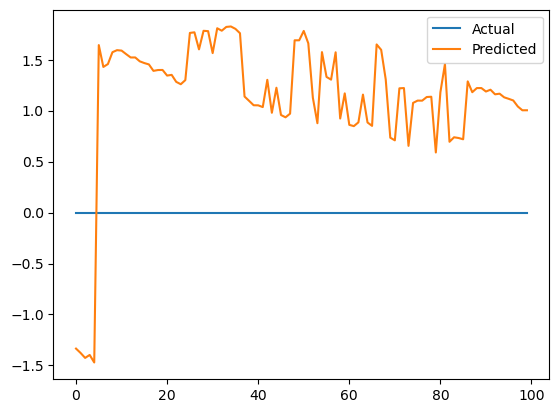

In [40]:

# Plotting the actual vs predicted values
plt.plot(inv_y[:100], label='Actual')
plt.plot(inv_yhat[:100], label='Predicted')
plt.legend()
plt.show()


In [41]:
from sklearn.metrics import r2_score

# Calculate R² score
r2 = r2_score(inv_y, inv_yhat)
print(f'R² score: {r2:.3f}')


R² score: 0.753


In [42]:
accuracy = np.mean(np.abs((inv_yhat - inv_y) / inv_y) < 0.1)  # Example threshold: within 10%
accuracy *= 100  # Convert to percentage
print(f'Custom Accuracy: {accuracy:.2f}%')


Custom Accuracy: 1.18%


C:\Users\sravanthi\AppData\Local\Temp\ipykernel_27820\1957903195.py:1: RuntimeWarning: divide by zero encountered in divide
  accuracy = np.mean(np.abs((inv_yhat - inv_y) / inv_y) < 0.1)  # Example threshold: within 10%
